In [1]:
import cv2
import torch
import random
import time
import numpy as np
import tensorrt as trt
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [2]:
w = '../onnxs/crowdhuman/crowd_640_origin_4batch.trt'
device = torch.device('cuda:0')
img = cv2.imread('../inference/images_sample/image1.jpg')

In [3]:
# Infer TensorRT Engine
Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())

bindings = OrderedDict()
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    print('@@@@@@@@@@@@@@@@',shape)
    # break
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

def postprocess(boxes,r,dwdh):
    dwdh = torch.tensor(dwdh*2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes

names = ['person','head']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

[03/17/2023-17:16:37] [TRT] [I] Loaded engine size: 136 MiB
[03/17/2023-17:16:39] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +1914, GPU +356, now: CPU 2693, GPU 13763 (MiB)
[03/17/2023-17:16:41] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +1217, GPU +419, now: CPU 3910, GPU 14182 (MiB)
[03/17/2023-17:16:41] [TRT] [W] TensorRT was linked against cuDNN 8.8.0 but loaded cuDNN 8.5.0
[03/17/2023-17:16:41] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +133, now: CPU 0, GPU 133 (MiB)
@@@@@@@@@@@@@@@@ (4, 3, 640, 640)
@@@@@@@@@@@@@@@@ (4, 1)
@@@@@@@@@@@@@@@@ (4, 100, 4)
@@@@@@@@@@@@@@@@ (4, 100)
@@@@@@@@@@@@@@@@ (4, 100)
[03/17/2023-17:16:

/tmp/ipykernel_25013/227830398.py:10: DeprecationWarning: Use get_tensor_name instead.
  name = model.get_binding_name(index)
/tmp/ipykernel_25013/227830398.py:11: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(model.get_binding_dtype(index))
/tmp/ipykernel_25013/227830398.py:12: DeprecationWarning: Use get_tensor_shape instead.
  shape = tuple(model.get_binding_shape(index))


42] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 5437, GPU 14724 (MiB)
[03/17/2023-17:16:42] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 5437, GPU 14732 (MiB)
[03/17/2023-17:16:42] [TRT] [W] TensorRT was linked against cuDNN 8.8.0 but loaded cuDNN 8.5.0
[03/17/2023-17:16:42] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +115, now: CPU 0, GPU 248 (MiB)
[03/17/2023-17:16:42] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


In [4]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)

im.shape

(1, 3, 640, 640)

In [5]:
img2 = cv2.imread('../inference/images/hard_hat_workers1006_png.rf.d5a41dc617566d9e997231d36aa0332c.jpg')

img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
image2 = img2.copy()
image2, ratio2, dwdh2 = letterbox(image2, auto=False)
image2 = image2.transpose((2, 0, 1))
image2 = np.expand_dims(image2, 0)
image2 = np.ascontiguousarray(image2)

im2 = image2.astype(np.float32)

im2.shape

(1, 3, 640, 640)

In [6]:
im = np.concatenate([im] * 4,0)
im.shape

(4, 3, 640, 640)

In [7]:
im = torch.from_numpy(im).to(device)
im/=255
im.shape


torch.Size([4, 3, 640, 640])

In [8]:

# warmup for 10 times
start = time.perf_counter()

for _ in range(2):

    binding_addrs['images'] = int(im.data_ptr())
    context.execute_v2(list(binding_addrs.values()))
    # print(f'Cost {time.perf_counter()-start} s')

print(f'Cost {time.perf_counter()-start} s')
nums = bindings['num_dets'].data
boxes = bindings['det_boxes'].data
scores = bindings['det_scores'].data
classes = bindings['det_classes'].data
nums.shape,boxes.shape,scores.shape,classes.shape


Cost 0.014499519998935284 s


(torch.Size([4, 1]),
 torch.Size([4, 100, 4]),
 torch.Size([4, 100]),
 torch.Size([4, 100]))

In [35]:
# start = time.perf_counter()

# for _ in range(10000):

#     binding_addrs['images'] = int(im.data_ptr())
#     context.execute_v2(list(binding_addrs.values()))
#     # print(f'Cost {time.perf_counter()-start} s')

# print(f'Cost {time.perf_counter()-start} s')

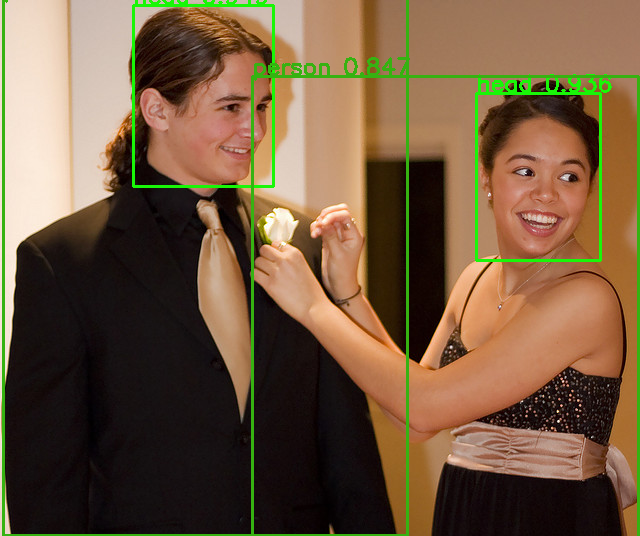

In [9]:
boxes1 = boxes[0,:nums[0][0]]
scores1 = scores[0,:nums[0][0]]
classes1 = classes[0,:nums[0][0]]

for box,score,cl in zip(boxes1,scores1,classes1):
    box = postprocess(box,ratio,dwdh).round().int()
    name = names[cl]
    color = colors[name]
    name += ' ' + str(round(float(score),3))
    cv2.rectangle(img,box[:2].tolist(),box[2:].tolist(),color,2)
    cv2.putText(img,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

Image.fromarray(img)

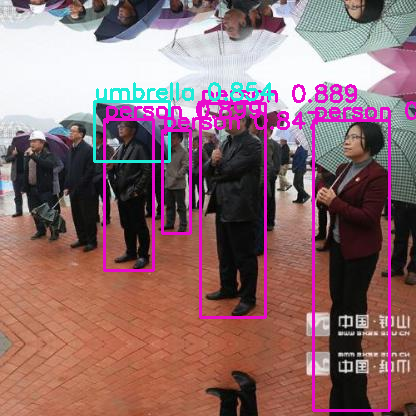

In [12]:
boxes2 = boxes[1,:nums[0][0]]
scores2 = scores[1,:nums[0][0]]
classes2 = classes[1,:nums[0][0]]

for box,score,cl in zip(boxes2,scores2,classes2):
    box = postprocess(box,ratio2,dwdh2).round().int()
    name = names[cl]
    color = colors[name]
    name += ' ' + str(round(float(score),3))
    cv2.rectangle(img2,box[:2].tolist(),box[2:].tolist(),color,2)
    cv2.putText(img2,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

Image.fromarray(img2)

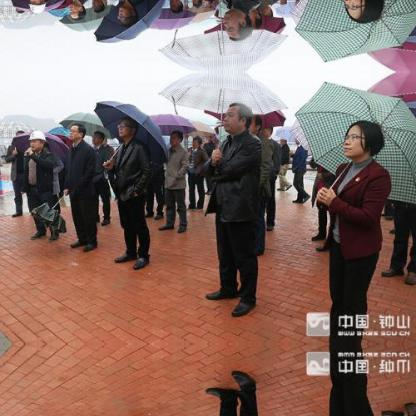